<a href="https://colab.research.google.com/github/yuanjinren/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/YuanjinRen_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ X] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [0]:
import numpy as np

In [0]:
def wrangle(X):
  X = X.copy()
  X['latitude'] = X['latitude'].replace(-2e-08,np.nan)
  cols_with_zeros = ['longitude','latitude','construction_year','gps_height','population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
    X[col+'_MISSING'] = X[col].isnull()
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)
  unusable_variance = ['recorded_by', 'id']
  X = X.drop(columns = unusable_variance)
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format = True)
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()
  X['permit']=X['permit'].replace(np.nan, False)
  X['public_meetingt']=X['public_meeting'].replace(np.nan, False)
  return X

In [0]:
train = wrangle(train)
test = wrangle(test)

In [0]:
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
target='status_group'
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

k=10
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring = 'accuracy')
print(f'score for {k} folds: ', scores)

score for 10 folds:  [0.81094276 0.81498316 0.81212121 0.80589226 0.81919192 0.803367
 0.81767677 0.8037037  0.8043771  0.81565657]


In [0]:
scores.mean()

0.8107912457912458

In [0]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [0]:
from scipy.stats import randint, uniform
param_distributions = {
    'randomforestclassifier__bootstrap':['True','False'],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__n_estimators':[50,100,150,160,170,180],
    'randomforestclassifier__min_samples_leaf':[1,2,4],
    'randomforestclassifier__max_features':['auto','sqrt','log2'],
    'randomforestclassifier__min_samples_split':[2,5,10]
}

In [0]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(
    
    pipeline,
    param_distributions=param_distributions,
    n_iter=7,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1

)

search.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.2s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 10.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross_validation accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__n_estimators': 160, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': 'True'}
Cross_validation accuracy 0.8135185185185186


In [0]:
pipeline = search.best_estimator_

In [0]:
y_pred = pipeline.predict(test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('YuanjinRen-submission-final.csv', index=False)

Use training set to plot confusion matrix

In [0]:
from sklearn.metrics import plot_confusion_matrix

In [0]:
y_train_pred = pipeline.predict(X_train)

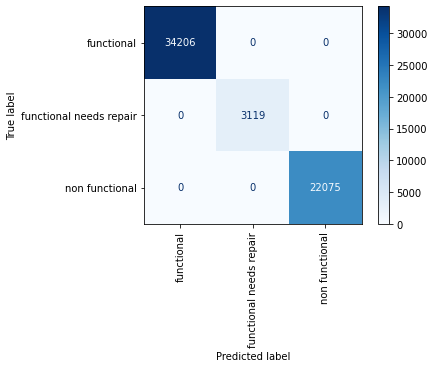

In [0]:
plot_confusion_matrix(pipeline, X_train, y_train_pred, values_format='.0f', 
                      xticks_rotation='vertical', cmap='Blues');

split training set into train and validation, then redo the prediction and confusion matrix

In [0]:
from sklearn.model_selection import train_test_split
train2, val = train_test_split(train, test_size=len(test),
                               stratify=train[target], random_state=42)

In [0]:
X_train2 = train2.drop(columns=target)
y_train2 = train2[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [0]:
pipeline.fit(X_train2, y_train2)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'sourc...
                 RandomForestClassifier(bootstrap='True', ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                          

In [0]:
y_val_pred = pipeline.predict(X_val)

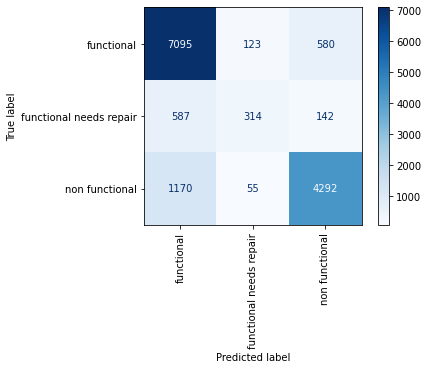

In [0]:
plot_confusion_matrix(pipeline, X_val, y_val, 
                      values_format = '.0f', xticks_rotation='vertical', cmap='Blues');

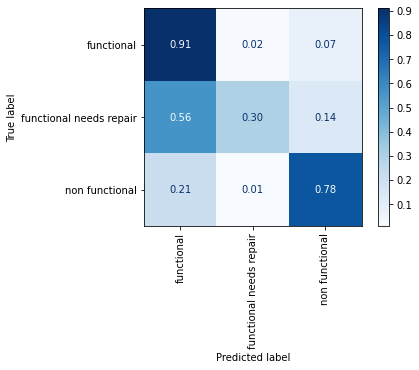

In [0]:
plot_confusion_matrix(pipeline, X_val, y_val,
                      normalize='true',
                      values_format='.2f',
                      xticks_rotation='vertical',cmap='Blues');

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
cm

array([[7095,  123,  580],
       [ 587,  314,  142],
       [1170,   55, 4292]])

In [0]:
normalized_cm = cm/cm.sum(axis=1)[:, np.newaxis]
normalized_cm

array([[0.90984868, 0.01577328, 0.07437805],
       [0.56279962, 0.30105465, 0.13614573],
       [0.21207178, 0.00996919, 0.77795904]])

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_val_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      7798
functional needs repair       0.64      0.30      0.41      1043
         non functional       0.86      0.78      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.77      0.66      0.69     14358
           weighted avg       0.81      0.81      0.81     14358

